# Latent Factor Model
### Libraries

In [1]:
%pylab inline
from __future__ import division
import numpy as np
import pandas as pd
import time
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import WordPunctTokenizer
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


### Load Data

In [2]:
# Open Reduced JSON files 
business_df = pd.read_json('yelp_dataset/TX_restaurants.json')
reviews_df = pd.read_json('yelp_dataset/TX_reviews.json')
users_df = pd.read_json('yelp_dataset/TX_users.json')
print('Total number of business: ', len(business_df))
print('Total number of reviews: ', len(reviews_df))
print('Total number of users: ', len(users_df))


Total number of business:  3270
Total number of reviews:  62936
Total number of users:  798


In [3]:
#Split Train / Test text.
def train_test_split(
            dataframes=[business_df,reviews_df,users_df],
            train_size = 0.8,
            seed=1000,):
    test_train_tuples = []
    for df in dataframes:
        n,m = df.shape
        train = df.sample(n=int(train_size*n), replace=False, random_state=seed)
        test = df.drop(train.index)
        test_train_tuples.append((train, test))
    return test_train_tuples

In [4]:
[(businesses_train,businesses_test),
 (reviews_train,reviews_test),
 (users_train, users_test)]=train_test_split([business_df, reviews_df, users_df])
businesses_train.shape,businesses_test.shape, reviews_train.shape,reviews_test.shape,users_train.shape,users_test.shape

((2616, 14), (654, 14), (50348, 9), (12588, 9), (638, 22), (160, 22))

In [5]:
# Select only Business ID, User ID, Stars & Text from the TX Reviews dataset.
reviews_train= reviews_train[['business_id','user_id', 'stars', 'text']]
reviews_train

,business_id,user_id,stars,text
922,KK-6rXbIo9B4-b_P5WO5Qg,xHCq7RGcHMfEoxsxrvwabw,5,I've been coming to the Clay Pit almost every ...
58542,0ilYusWkJPzD-aYGYtIsMg,6BZd8ES6q7Uz9-kxJ8O-4A,4,after so many failings in recent visits. wife...
35832,zDVjN3dC9EfQno21m3O8Pg,o_m8kQt5j3gv7WfqsGhFBw,2,I had high hopes for Stiles Switch. It's in wa...
33918,A7M_2DiB8Xvj3NTs1RGfDg,XbfvqA7xebv5IXZWyK76Aw,4,"Half off drinks, 25% off bottles of wine and d..."
17808,bXLfGGLx61eEjjL2iKkO3g,FzMhWsLqyQbNq-7d--o4sw,5,"One of my Dallas favorites, now with two locat..."
...,...,...,...,...
56362,P3CFVL-yni3P74QtnHuVfA,ezM7052Nk608iuDnunmTfA,3,We came here looking for some good beer and gr...
31368,GdR9YyZ0e9VeP0r9C303SQ,VSbOAu9bmctgDe_HRiMgEA,4,four words - \n\n- half price happy hour\n\n- ...
38280,iamuoz587n2gHSYdt1ENog,efMDfLm2k7LY6l5sg4t8fQ,3,Came here for a large group get together and I...
59174,1-0Jhx0QpzPk9cGcMYRUDA,Yq-EWBe--n6rQ8JBSit39A,5,"When I visited UT for an orientation, this pla..."


In [6]:
import string
from nltk.corpus import stopwords
stop = []
for word in stopwords.words('english'):
    s = [char for char in word if char not in string.punctuation]
    stop.append(''.join(s))  

    # Function to clean the reviews text.
def cleaning_text(mess):
    revmovePunctuation = [char for char in mess if char not in string.punctuation]
    revmovePunctuation = ''.join(revmovePunctuation)
    # Remove all stopwords
    return " ".join([word for word in revmovePunctuation.split() if word.lower() not in stop])

In [7]:
reviews_train['text'] = reviews_train['text'].apply(cleaning_text)
reviews_train['text']

922      Ive coming Clay Pit almost every week six year...
58542    many failings recent visits wife decided go we...
35832    high hopes Stiles Switch walking distance hous...
33918    Half drinks 25 bottles wine discounts bar menu...
17808    One Dallas favorites two locations Austin go o...
                               ...                        
56362    came looking good beer great bites beer point ...
31368    four words half price happy hour oyster platte...
38280    Came large group get together know store place...
59174    visited UT orientation place one first Austin ...
5143     periodically lunch great experience every time...
Name: text, Length: 50348, dtype: object

In [8]:
"""
- Subsets Tables from the Original Reviews Data.
- To create Features from the Train Set ONLY
1) Users with Text. (50348 rows × 2 columns)
2) Business with text. (50348 rows × 2 columns)
"""
user_text = reviews_train[['user_id','text']]
business_text = reviews_train[['business_id','text']]
user_text.shape, business_text.shape

((50348, 2), (50348, 2))

In [9]:
# Compile All corresponding Reviews to each User and to each Business.
user_text = user_text.groupby('user_id').agg({'text': ' '.join})
business_text = business_text.groupby('business_id').agg({'text': ' '.join})

# Combine review of User 'xHCq7RGcHMfEoxsxrvwabw'
user_text.loc['xHCq7RGcHMfEoxsxrvwabw']['text']

'Ive coming Clay Pit almost every week six years Well allowed Rotary club meet Thursday 6pm upstairs event room staff amazing know many first name basis foodyum Always great best happy hour 12 appsand wide variety beverages choose favorite bar foods lamb kabobs hummus naan samosa chat dining main room cant go wrong tikka masala curry dishes like lamb get say Im fan understatement love restaurant went four friends celebrate birthday dining room reminded grandmas house case Russian grandma cozy homey lace table cloths family photos hanging wall server nice attentive helped us deciding orders greeted shot vodka course food amazing beet salad porkbeef palmeni friends beef strogonov started couple pirozhkis server brought piece Russian cake birthday definitely come back dinner also try infused vodkas bar area looks like fun time waiting Ive wanting try restaurant disappoint friend got early 5 oclock Saturday opened able get table Id recommend trying get reservation come later since popular 

In [10]:
user_text

,text
user_id,
-0MQ4webH2uc1ZAsGsNENg,pizza stuff dreams think put crack dough get a...
-2sNTzGyci98Mp9PmPRg8w,Oh Trudys Years ago younger days almost magica...
-4RH83ibNRpwj8NlBwtMdQ,First time eat Ordered chicken Pena pasta Dish...
-8QoOIfvwwxJ4sY201WP5A,great way spend Friday afternoon sitting patio...
-OGWTHZng0QNhvc8dhIjyQ,go Pluckers know going get Consistently OK foo...
...,...
zgLUWGBKrSoIIH3E2XLvNQ,Decent delectables decent staff keeps us comin...
zlL_PbFTXjrGXhTbPsjmlQ,Initially convinced 4 generous banh mi South A...
zonT-KQFJiejFNUrs2KR0Q,kinda flipped first visit APG menu EXACTLY piz...


In [11]:
# Combined reviews By User and by Business table size
business_text.shape, user_text.shape

((779, 1), (798, 1))

In [12]:
"""
Getting user_id and most relevant info for Kevan (Kevan is Not on users_train Set.)
"""
user_X = users_test[users_test['name']=='Kevan']
user_X

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
473,-OGWTHZng0QNhvc8dhIjyQ,Kevan,197,2007-07-14 17:16:27,329,85,97,"2011,2012,2015,2016,2017,2018","s8nkbQAlrVPfg1u4anGKtw, o4ZZnp8ugpfhzLAa6jFenA...",4,...,5,0,0,0,6,11,6,6,3,2


In [13]:
"""
Vectorization with Term Frequency Inverse Doc. Frequency (TF-IDF) to extract the features from the text.
"""
# Sparse Matrix User Text vectorizer (798 x 5000 )
user_vectorizer = TfidfVectorizer(tokenizer = WordPunctTokenizer().tokenize, max_features=5000)
user_vectors = user_vectorizer.fit_transform(user_text['text'])

# Sparse mMtrix Business Text vectorizer (779 x 5000)
business_vectorizer = TfidfVectorizer(tokenizer = WordPunctTokenizer().tokenize, max_features=5000)
business_vectors = business_vectorizer.fit_transform(business_text['text'])
user_vectors, business_vectors

(<798x5000 sparse matrix of type '<class 'numpy.float64'>'
 	with 1067238 stored elements in Compressed Sparse Row format>,
 <779x5000 sparse matrix of type '<class 'numpy.float64'>'
 	with 1061380 stored elements in Compressed Sparse Row format>)

In [14]:
"""
Users / Businesses with Stars Matrix. (798 rows × 779 columns)
"""
user_bussiness_stars = pd.pivot_table(reviews_train, values='stars', index=['user_id'], columns=['business_id'])
R = user_bussiness_stars
R

business_id,-4ofMtrD7pSpZIX5pnDkig,-85pDrVcAdzNK55bFpintg,-BBSLCjzw3i2PHuwJ_dabA,-Ce8p148xb0-4dv_3zwm3A,-WA4tNsXZq5sxcGw8a5_IQ,-_GnwXmzC3DXsHR9nyaC2g,-jQOsyXnAMKu6ND7ongXFg,-qjkQHH-5O8BAztc6udOuw,-waa6lH9SmAkaKiLx74_FA,0-Y_m4TJZufHBVozbMOqbA,...,z3JW-nsdfC8ijst_PSeMIA,z4fQL2IHUR4ENonH7A_9tQ,zDVjN3dC9EfQno21m3O8Pg,zE0EGIsOdAO83xE3CypN-A,zFaHweOJ40jjtvpGTjlspw,zM98ZSIJyuBQabyYornLpw,zVILoCmmDSgcM5bc2BKVWg,zZIWHmITwqaC8OhnPkjEIQ,zerPYZ-lid5CG27a1-7YMw,zyHMtStYlKG67WRprp6GZQ
user_id,,,,,,,,,,,,,,,,,,,,,
-0MQ4webH2uc1ZAsGsNENg,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,4.0,2.0,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2sNTzGyci98Mp9PmPRg8w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,3.0
-4RH83ibNRpwj8NlBwtMdQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-8QoOIfvwwxJ4sY201WP5A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-OGWTHZng0QNhvc8dhIjyQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zgLUWGBKrSoIIH3E2XLvNQ,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zlL_PbFTXjrGXhTbPsjmlQ,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zonT-KQFJiejFNUrs2KR0Q,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN


## Matrix Factorization

In [15]:
# r = user_bussiness_stars
Q = pd.DataFrame(user_vectors.toarray(), index=user_text.index, columns=user_vectorizer.get_feature_names())
P = pd.DataFrame(business_vectors.toarray(), index=business_text.index, columns=business_vectorizer.get_feature_names())

In [16]:
# Calculate the Error for the Function
def funError(R, Q, P, K, lambd):
    e = 0
    for i in range(len(R)):
        for j in range(len(R[i])):
            if R[i][j] > 0:
                # loss Function ErrorSum
                e = e + pow(R[i][j]-np.dot(Q[i,:],P[:,j]), 2)
                # Adding Regularization
                for k in range(K):
                    # Error + ||Q||^2 + ||P||^2
                    e = e + (lambd/2) * ( pow(Q[i][k], 2) + pow(P[k][j], 2) )
    return e

def fit_stats(funError, samples_count, products_count):
    print('Training Complete...')
    print('------------------------------')
    print('Stats:')
    print('Users: ' + str(samples_count))
    print('Restaurants: ' + str(products_count))

In [17]:
def matrix_factorization(R, K, learn_rate, iterations, lambd):
    R = np.array(R)
    M = len(R[0])
    N = len(R)
    P = np.random.rand(M, K)
    Q = np.random.rand(N, K)
    P = P.T
    print('Running Stochastic Gradient Descent for %s iterations.' % iterations)
    boom = False
    error = []
    for step in range(iterations):
        if boom: break
        print('Iteration :',step, '...', end=" "),  
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    err_ij = R[i][j] - np.dot(Q[i, :], P[:, j])
                    for k in range(K):
                        Q[i][k] = Q[i][k] + learn_rate * (2 * err_ij * P[k][j] - lambd * Q[i][k])
                        P[k][j] = P[k][j] + learn_rate * ( 2 * err_ij * Q[i][k] - lambd * P[k][j])

        #Measure Error
        error.append(funError(R, Q, P, K, lambd))
        print('done.', end=" "),
        print('Error:[ %0.2f]' % error[step])    
    Q = Q
    P = P.T
    fit_stats(error, M, N)
    return (Q, P, error)

## Train New Data.

In [18]:
 """
 ----RUN THIS MODEL ONLY TO TRAIN NEW DATA OR TO CHANGE THE PARAMETERS----
 
Q = |V|*K (User features)
P = |U|*K (Business features)
R = |A|[User ,Business ,Real Rating] Matrix. (80 % of the origiinal dataset)
K = Number of latent features
iterations  = steps
learn_rate = Learning Rate
lambd = Regularization Parameter
error_limit = Convergeance Threshold
nQ = Updated value of P
nP = Updated value of Q
#P = numpy.random.rand(N,K)
#Q = numpy.random.rand(M,K)
"""
K = 5
learn_rate = 0.02
lambd = 0.01
iterations  = 5

start = time.time()
nQ, nP ,er = matrix_factorization(R, K, learn_rate, iterations , lambd) 
end = time.time()
duration = end-start

print('Error: %0.2f' % er[-1])
print('------------------------------')
print("Time taken to train the Model: %d seconds" %duration)

Running Stochastic Gradient Descent for 5 iterations.
Iteration : 0 ... done. Error:[ 233311.73]
Iteration : 1 ... done. Error:[ 45677.09]
Iteration : 2 ... done. Error:[ 40070.08]
Iteration : 3 ... done. Error:[ 39602.85]
Iteration : 4 ... done. Error:[ 38647.73]
Training Complete...
------------------------------
Stats:
Users: 779
Restaurants: 798
Error: 38647.73
------------------------------
Time taken to train the Model: 10 seconds


Text(0.5, 1.0, 'Gradient Descent : Error vs. Iterations')

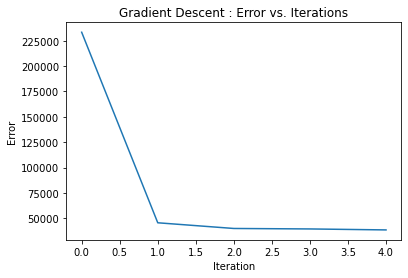

In [19]:
f0 = pylab.figure()
p1 = f0.add_subplot(111)
p1.plot([i for i in range(iterations)],er) 
p1.set_xlabel("Iteration")
p1.set_ylabel("Error")
p1.set_title("Gradient Descent : Error vs. Iterations")

## Save The Model in a pickle file

In [ ]:
# STORE P, Q and vectorizer in pickle file
import pickle
output = open('yelp_dataset/yelp_recommendation_model_LFM_v2_5.pkl', 'wb')
pickle.dump(nP,output)
pickle.dump(nQ,output)
pickle.dump(user_vectorizer,output)
output.close()

## Load The Model to Test

In [20]:
# LOAD P, Q and vectorizer in pickle file
import pickle
input = open('yelp_dataset/yelp_recommendation_model_LFM_v2_5.pkl','rb')
nP = pickle.load(input)
nQ = pickle.load(input)
userid_vectorizer = pickle.load(input)
input.close()

### Testing the Moded: 
* Input: Preferences in Text form.  
* Output: Top Ten Recommendations. 

In [21]:
words = "This is definitely a restaurant I would drive to north Austin  for again. I dined here after a seminar on a Friday and it didn't disappoint."
test_df= pd.DataFrame([words], columns=['text'])
test_df['text'] = test_df['text'].apply(cleaning_text)
test_vectors = userid_vectorizer.transform(test_df['text'])
test_v_df = pd.DataFrame(test_vectors.toarray(), index=test_df.index, columns=userid_vectorizer.get_feature_names())

predictItemRating=pd.DataFrame(np.dot(test_v_df.loc[0],P.T),index=P.index,columns=['Rating'])
topRecommendations=pd.DataFrame.sort_values(predictItemRating,['Rating'],ascending=[0])[:10]

for i in topRecommendations.index:
    print(business_df[business_df['business_id']==i]['name'].iloc[0])
    print(business_df[business_df['business_id']==i]['categories'].iloc[0])
    print(str(business_df[business_df['business_id']==i]['stars'].iloc[0])+ ' '+str(business_df[business_df['business_id']==i]['review_count'].iloc[0]))
    print('')

North Italia
Pizza, Italian, Venues & Event Spaces, Breakfast & Brunch, Event Planning & Services, Restaurants
4.0 1292

Sala and Betty
Sandwiches, Food, Breakfast & Brunch, American (New), Diners, Cafes, Restaurants, Beer, Wine & Spirits
4.5 518

Andiamo Ristorante
Italian, Restaurants
4.0 419

Fork & Vine
American (New), Bars, Restaurants, Nightlife, Wine Bars
4.0 245

Olive & June
Italian, Restaurants, American (New)
4.0 613

Hank's
Restaurants, American (Traditional), Coffee & Tea, Cafes, Nightlife, Bars, Food, Breakfast & Brunch
3.5 486

Eberly
Restaurants, Breakfast & Brunch, Nightlife, Bars, Pubs, American (Traditional)
4.0 467

Hillside Farmacy
Bars, Beer, Wine & Spirits, Breakfast & Brunch, Restaurants, Seafood, American (New), Diners, Food, Nightlife
3.5 916

Hecho En Mexico
Restaurants, Bars, Mexican, Nightlife
4.0 541

Workhorse Bar
Nightlife, Bars, Restaurants, Local Flavor, American (Traditional), Dive Bars
4.0 293



In [ ]:
kevan

-OGWTHZng0QNhvc8dhIjyQ

***